# Problemas

Nesta prática iremos usar tudo que aprendemos durante o módulo.
Logo, **seu objetivo é determinar e implementar um modelo para cada problema.**

Lembre-se de definir:

1. o Dataloader, tratando a forma de ler as imagens de cada dataset, experimentando transformações diferentes (resize, crop, flips e etc.)
1. uma arquitetura (tentem usar tanto arquiteturas existentes como propor novas usando camadas de convolução, pooling, e densas),
1. uma função de custo
1. um algoritmo de otimização (agora, como os problemas são maiores, será possível notar mais claramente a diferença entre diferentes algoritmos).





In [5]:
# %load_ext nbproxy
!pip install torchsummary

In [6]:
import time, os, sys, numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

import PIL
from PIL import Image
from torch import optim
from torchsummary import summary

# Test if GPU is avaliable, if not, use cpu instead
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n = torch.cuda.device_count()
devices_ids= list(range(n))

In [7]:
# funções básicas

# Função usada para calcular acurácia
def evaluate_accuracy(data_iter, net, loss):
    """Evaluate accuracy of a model on the given data set."""

    acc_sum, n, l = torch.Tensor([0]), 0, 0
    net.eval()
    with torch.no_grad():
      for X, y in data_iter:
          #y = y.astype('float32')
          X, y = X.to(device), y.to(device)
          y_hat = net(X)
          l += loss(y_hat, y).sum()
          acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
          n += y.size()[0]

    return acc_sum.item() / n, l.item() / len(data_iter)

# Função usada no treinamento e validação da rede
def train_validate(net, train_iter, test_iter, batch_size, trainer, loss,
                   num_epochs):
    print('training on', device)

    if device.type == 'cuda':
        torch.cuda.empty_cache()

    for epoch in range(num_epochs):
        net.train()
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        for X, y in train_iter:
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            trainer.zero_grad()
            l = loss(y_hat, y).sum()
            l.backward()
            trainer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.size()[0]
        test_acc, test_loss = evaluate_accuracy(test_iter, net, loss)
        print('epoch %d, train loss %.4f, train acc %.3f, test loss %.4f, '
              'test acc %.3f, time %.1f sec'
              % (epoch + 1, train_l_sum / len(train_iter), train_acc_sum / n, test_loss,
                 test_acc, time.time() - start))

        torch.cuda.empty_cache()


## Problema 1 - Exemplo

Neste problema, classificaremos imagens histólogica do dataset [*Colorectal Histology*](https://www.kaggle.com/kmader/colorectal-histology-mnist).
Neste caso, vamos receber imagens com tamanho de $150\times 150$ pixels e classificá-las entre 8 classes:

1. tumor
1. stroma
1. complex
1. lympho
1. debris
1. mucosa
1. adipose
1. empty

In [8]:
!wget https://www.dropbox.com/s/k0f6vxyhcr6gh1r/Kather_texture_2016_image_tiles_5000.zip
!unzip -q Kather_texture_2016_image_tiles_5000.zip

--2025-07-03 20:41:13--  https://www.dropbox.com/s/k0f6vxyhcr6gh1r/Kather_texture_2016_image_tiles_5000.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/eyds9w2eqfkq7rx86z4oj/Kather_texture_2016_image_tiles_5000.zip?rlkey=w9zrj0hx7dflh7913i4ds0fi7 [following]
--2025-07-03 20:41:13--  https://www.dropbox.com/scl/fi/eyds9w2eqfkq7rx86z4oj/Kather_texture_2016_image_tiles_5000.zip?rlkey=w9zrj0hx7dflh7913i4ds0fi7
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc4cd1011250619a6046f100cfd1.dl.dropboxusercontent.com/cd/0/inline/CszgZhrBQhfsgxOYkkN-L3tThhH4csO7CfEfrX2xSHSWuhIpQzXoii_rSmVn4aJF3WC7yDJ8DGgIMgMhjl8hcjv3UOJynS1Cv5-VJYJ9j4_g8YplPr4xWDYVo3HGrlYrvPM/file# [following]
--2025-07-03 20:41:14--  https://uc

In [9]:
class HistologyDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform, train=False, calc_norm=True, has_norm=True):
        self.root = root
        self.train = train
        self.calc_norm = calc_norm
        self.has_norm = has_norm
        self.le = {'tumor': 0, 'stroma': 1, 'complex': 2, 'lympho': 3,
                   'debris': 4, 'mucosa': 5, 'adipose': 6, 'empty': 7} # dicionário para definir o label de cada classe
        self.transform = transform
        self.load_images()

    def load_images(self):
        self.img_list, self.labels = self.read_images(root=self.root)

    def read_images(self, root):
        # Leitura das imagens do dataset
        # para este caso, o dataset divide em pastas as imagens de cada classe correspondente
        # portanto, vamos percorrer essas pastas, adicionando as primeiras 500 imagens para o conjunto de treino
        # o restante das imagens (a partir da 500) são adicionadas na validação
        # o label é definido de acordo com o nome da pasta pelo dicionário self.le definido acima
        # por exemplo: a pasta 01_TUMOR vai ser correspondente ao self.le['tumor'], que é igual a 0
        img_list, labels = [], []
        if self.train is True:
          for folder in os.listdir(self.root):
            for num, img_name in enumerate(os.listdir(os.path.join(self.root, folder))):
                if num < 500:
                  img_list.append(os.path.join(self.root, folder, img_name))
                  labels.append(self.le[folder.split('_')[1].lower()])
        else:
          for folder in os.listdir(os.path.join(self.root)):
            for num, img_name in enumerate(os.listdir(os.path.join(self.root, folder))):
                if num >= 500:
                  img_list.append(os.path.join(self.root, folder, img_name))
                  labels.append(self.le[folder.split('_')[1].lower()])

        return img_list, labels

    def __getitem__(self, item):
        # retorna uma imagem para o treino/teste
        if self.has_norm is True:
            # normaliza a imagem se has_norm for setado como True
            cur_img = self.normalize_image(self.transform(Image.open(self.img_list[item])))
        else:
            # apenas converte a imagem para tensor, sem normalizar
            cur_img = self.transform(Image.open(self.img_list[item]))
        cur_label = self.labels[item]
        return cur_img, cur_label

    def __len__(self):
        return len(self.img_list)

    def normalize_image(self, img):
        # normaliza uma imagem
        # se calc_norm for True, normaliza pela subtração da média dividida pelo desvio para cada canal da imagem
        # se calc_norm for False, normaliza pelos valores pré-definidos de média e desvio padrão
        if self.calc_norm is True:
            for i in range(img.shape[0]):
                mu = img[i, :, :].mean()
                std = img[i, :, :].std()
                img[i, :, :] = ((img[i, :, :] - mu) / std)
        else:
            img = torchvision.transforms.functional.normalize(img,
                                                mean=torch.Tensor([0.485, 0.456, 0.406]),
                                                std=torch.Tensor([0.229, 0.224, 0.225]))
        return img


def load_data(dataset, root, batch_size, resize=None):
    # o transformer define a sequência de transformações que serão aplicadas na imagem
    # neste caso, a sequência é um redimensionamento da imagem (caso a variável resize seja definida)
    # seguido de uma transformação para tensor
    # várias outras transformações estão disponíveis no Pytorch, como crops, flips, espelhamento e etc.
    transformer = []
    if resize is not None:
        transformer += [torchvision.transforms.Resize(size=(resize,resize))]
    transformer += [torchvision.transforms.ToTensor()]
    transformer = torchvision.transforms.Compose(transformer)

    train = dataset(root=root, transform=transformer, train=True) #obtem dataset de treino
    test = dataset(root=root, transform=transformer, train=False) #obtem dataset de validação
    num_workers = 0 if sys.platform.startswith('win32') else 4

    train_iter = torch.utils.data.DataLoader(train,
                                  batch_size, shuffle=True,
                                  num_workers=num_workers) # criação do dataloader de treino
    test_iter = torch.utils.data.DataLoader(test,
                                 batch_size, shuffle=False,
                                 num_workers=num_workers) # criação do dataloader de teste
    return train_iter, test_iter

# carregamento do dado
batch_size = 64
train_iter, test_iter = load_data(HistologyDataset, 'Kather_texture_2016_image_tiles_5000', batch_size, resize=None)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [10]:
# IMPLEMENTE AQUI SUA REDE E DEFINIÇÃO DE LOSS E OTIMIZADOR

# experimente criar redes do zero com o conhecimento adquirido no curso até agora
# experimente também replicar redes já estabelecidas (alexnet, lenet, vgg e etc)
# experimente também utilizar as redes pré-treinadas já implementadas no torchvision
# para o caso de rede pré-treinada, lembre-se de modificar a saída da rede para o número de classes do problema

class HistologyCNN(nn.Module):
    def __init__(self, num_classes=8):
        super(HistologyCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 * 18 * 18, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

num_epochs = 15
lr = 0.001
batch_size = 64
wd_lambda = 0.0001

model = HistologyCNN(num_classes=8).to(device)
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd_lambda)


# treinamento e validação
train_validate(model, train_iter, test_iter, batch_size, optimizer, loss, num_epochs)

training on cuda
epoch 1, train loss 1.4327, train acc 0.452, test loss 0.7875, test acc 0.698, time 9.0 sec
epoch 2, train loss 0.7986, train acc 0.708, test loss 0.7328, test acc 0.732, time 8.6 sec
epoch 3, train loss 0.6339, train acc 0.775, test loss 0.5822, test acc 0.763, time 8.4 sec
epoch 4, train loss 0.4754, train acc 0.830, test loss 0.5958, test acc 0.784, time 7.5 sec
epoch 5, train loss 0.3643, train acc 0.866, test loss 0.5615, test acc 0.796, time 8.4 sec
epoch 6, train loss 0.2572, train acc 0.906, test loss 0.6141, test acc 0.790, time 9.1 sec
epoch 7, train loss 0.1993, train acc 0.927, test loss 0.5707, test acc 0.793, time 7.5 sec
epoch 8, train loss 0.1264, train acc 0.957, test loss 0.7184, test acc 0.777, time 8.4 sec
epoch 9, train loss 0.1066, train acc 0.960, test loss 0.6182, test acc 0.825, time 8.4 sec
epoch 10, train loss 0.0719, train acc 0.975, test loss 0.7230, test acc 0.815, time 7.8 sec
epoch 11, train loss 0.0627, train acc 0.980, test loss 0.8140

## Problema 2

Neste problema, classificaremos imagens de sensoriamento remoto de plantações de café do dataset público [Brazilian Coffee Scenes](http://www.patreo.dcc.ufmg.br/2017/11/12/brazilian-coffee-scenes-dataset/).
Neste caso, , vamos receber imagens de $64\times 64$ pixels e classificá-las entre duas classes:

1. café, e
2. não café.

In [14]:
# Baixando o dataset
!wget http://www.patreo.dcc.ufmg.br/wp-content/uploads/2017/11/brazilian_coffee_dataset.zip
!unzip -q brazilian_coffee_dataset.zip

--2025-07-03 20:54:54--  http://www.patreo.dcc.ufmg.br/wp-content/uploads/2017/11/brazilian_coffee_dataset.zip
Resolving www.patreo.dcc.ufmg.br (www.patreo.dcc.ufmg.br)... 150.164.144.15
Connecting to www.patreo.dcc.ufmg.br (www.patreo.dcc.ufmg.br)|150.164.144.15|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4796290 (4.6M) [application/zip]
Saving to: ‘brazilian_coffee_dataset.zip.1’

brazilian_coffee_da 100%[===================>]   4.57M  1.59MB/s    in 2.9s    

2025-07-03 20:54:57 (1.59 MB/s) - ‘brazilian_coffee_dataset.zip.1’ saved [4796290/4796290]

replace brazilian_coffee_scenes/fold5.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [15]:
class CoffeeDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform, train=False, calc_norm=True, has_norm=True):
        self.root = root
        self.train = train
        self.calc_norm = calc_norm
        self.has_norm = has_norm
        self.load_images()
        self.transform = transform

    def load_images(self):
        self.img_list, self.labels = self.read_images(root=self.root)

    def read_images(self, root):
        # para este dataset, existem 5 pastas (fold1, fold2, ..., fold5) com as imagens
        # e existem 5 arquivos txts (fold1.txt, fold2.txt, ..., fold5.txt) com o nome das imagens correspondentes
        # nos arquivos txts, cada linha representa uma imagem seguindo o formato {classe}.{nome da img}
        # sendo classe igual a coffee ou noncoffee (0 ou 1)
        # tratamos o nome das imagens de acordo com cada linha do arquivo (não esquecendo de adicionar o .jpg)
        # convertemos o label em 0 ou 1 dependendo da classe
        # Vamos utilizar o fold 1 como validação e o restante dos folds como treino
        img_list, labels = [], []
        if self.train is True:
          for i in range(1,5):
            data_file = open(os.path.join(root, 'fold' + str(i+1) + '.txt'), "r")  # arquivo com nome das imagens
            data_list = [i.replace('\n', '') for i in data_file.readlines()]
            for row in data_list:
                img_name = '.'.join(row.split('.')[1:])
                img_list.append(os.path.join(root, 'fold' + str(i+1), img_name + '.jpg'))
                labels.append(0 if row.split('.')[0] == 'coffee' else 1)
        else:
            data_file = open(os.path.join(root, 'fold1.txt'), "r")  # arquivo com nome das imagens
            data_list = [i.replace('\n', '') for i in data_file.readlines()]
            for row in data_list:
                img_name = '.'.join(row.split('.')[1:])
                img_list.append(os.path.join(root, 'fold1', img_name + '.jpg'))
                labels.append(0 if row.split('.')[0] == 'coffee' else 1)

        return img_list, labels

    def __getitem__(self, item):
        if self.has_norm is True:
            cur_img = self.normalize_image(self.transform(Image.open(self.img_list[item])))
        else:
            cur_img = self.transform(Image.open(self.img_list[item]))
        cur_label = self.labels[item]
        return cur_img, cur_label

    def __len__(self):
        return len(self.img_list)

    def normalize_image(self, img):
        if self.calc_norm is True:
            for i in range(img.shape[0]):
                mu = img[i, :, :].mean()
                std = img[i, :, :].std()
                img[i, :, :] = ((img[i, :, :] - mu) / std)
        else:
            img = torchvision.transforms.functional.normalize(img,
                                                mean=torch.Tensor([0.485, 0.456, 0.406]),
                                                std=torch.Tensor([0.229, 0.224, 0.225]))
        return img


def load_data(dataset, root, batch_size, resize=None):
    # o transformer define a sequência de transformações que serão aplicadas na imagem
    # neste caso, a sequência é um redimensionamento da imagem (caso a variável resize seja definida)
    # seguido de uma transformação para tensor
    # várias outras transformações estão disponíveis no Pytorch, como crops, flips, espelhamento e etc.
    transformer = []
    if resize is not None:
        transformer += [torchvision.transforms.Resize(size=(resize,resize))]
    transformer += [torchvision.transforms.ToTensor()]
    transformer = torchvision.transforms.Compose(transformer)

    train = dataset(root=root, transform=transformer, train=True) #obtem dataset de treino
    test = dataset(root=root, transform=transformer, train=False) #obtem dataset de validação
    num_workers = 0 if sys.platform.startswith('win32') else 4

    train_iter = torch.utils.data.DataLoader(train,
                                  batch_size, shuffle=True,
                                  num_workers=num_workers) # criação do dataloader de treino
    test_iter = torch.utils.data.DataLoader(test,
                                 batch_size, shuffle=False,
                                 num_workers=num_workers) # criação do dataloader de teste
    return train_iter, test_iter

batch_size = 64
train_iter, test_iter = load_data(CoffeeDataset, 'brazilian_coffee_scenes', batch_size, resize=None)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [16]:
# IMPLEMENTE AQUI SUA REDE E DEFINIÇÃO DE LOSS E OTIMIZADOR

# experimente criar redes do zero com o conhecimento adquirido no curso até agora
# experimente também replicar redes já estabelecidas (alexnet, lenet, vgg e etc)
# experimente também utilizar as redes pré-treinadas já implementadas no torchvision
# para o caso de rede pré-treinada, lembre-se de modificar a saída da rede para o número de classes do problema

import torch
import torch.nn as nn
import torch.nn.functional as F

class CoffeeCNN(nn.Module):
    def __init__(self):
        super(CoffeeCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2)

        self.fc1 = nn.Linear(128 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 1)

        self.dropout = nn.Dropout(0.6)


    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.conv1(x)), negative_slope=0.1)
        x = self.pool1(x)
        x = self.dropout(x)

        x = F.leaky_relu(self.bn2(self.conv2(x)), negative_slope=0.1)
        x = self.pool2(x)
        x = self.dropout(x)

        x = F.leaky_relu(self.bn3(self.conv3(x)), negative_slope=0.1)
        x = self.pool3(x)
        x = self.dropout(x)

        x = x.view(-1, 128 * 8 * 8)
        x = F.leaky_relu(self.fc1(x), negative_slope=0.1)
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))

        return x

num_epochs = 30
lr = 0.001
batch_size = 64


model = CoffeeCNN().to(device)
loss = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

# treinamento e validação
train_validate(model, train_iter, test_iter, batch_size, optimizer, lambda y_hat, y: loss(y_hat, y.float().view(-1, 1)), num_epochs)

training on cuda
epoch 1, train loss 2.9101, train acc 0.500, test loss 0.6520, test acc 0.500, time 2.3 sec
epoch 2, train loss 0.6199, train acc 0.500, test loss 0.5770, test acc 0.500, time 2.0 sec
epoch 3, train loss 0.5709, train acc 0.500, test loss 0.5355, test acc 0.500, time 2.0 sec
epoch 4, train loss 0.5403, train acc 0.500, test loss 0.4772, test acc 0.500, time 2.0 sec
epoch 5, train loss 0.5167, train acc 0.500, test loss 0.5928, test acc 0.500, time 2.3 sec
epoch 6, train loss 0.5051, train acc 0.500, test loss 0.5849, test acc 0.500, time 2.6 sec
epoch 7, train loss 0.4896, train acc 0.500, test loss 0.7534, test acc 0.500, time 2.1 sec
epoch 8, train loss 0.4650, train acc 0.500, test loss 0.5641, test acc 0.500, time 2.0 sec
epoch 9, train loss 0.4505, train acc 0.500, test loss 0.5770, test acc 0.500, time 2.0 sec
epoch 10, train loss 0.4384, train acc 0.500, test loss 0.4671, test acc 0.500, time 2.0 sec
epoch 11, train loss 0.4407, train acc 0.500, test loss 0.5543

## Problema 3

Neste problema, classificaremos imagens gerais de sensoriamento remoto do dataset público [UCMerced](http://weegee.vision.ucmerced.edu/datasets/landuse.html).
Neste caso, vamos receber imagens de $256\times 256$ pixels e classificá-las entre 21 classes:

1. agricultural
1. airplane
1. baseballdiamond
1. beach
1. buildings
1. chaparral
1. denseresidential
1. forest
1. freeway
1. golfcourse
1. harbor
1. intersection
1. mediumresidential
1. mobilehomepark
1. overpass
1. parkinglot
1. river
1. runway
1. sparseresidential
1. storagetanks
1. tenniscourt

In [17]:
# Baixando o dataset
!wget http://weegee.vision.ucmerced.edu/datasets/UCMerced_LandUse.zip
!unzip -q UCMerced_LandUse.zip

--2025-07-03 20:59:05--  http://weegee.vision.ucmerced.edu/datasets/UCMerced_LandUse.zip
Resolving weegee.vision.ucmerced.edu (weegee.vision.ucmerced.edu)... 169.236.184.65
Connecting to weegee.vision.ucmerced.edu (weegee.vision.ucmerced.edu)|169.236.184.65|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 332468434 (317M) [application/zip]
Saving to: ‘UCMerced_LandUse.zip’

UCMerced_LandUse.zi 100%[===================>] 317.07M  11.6MB/s    in 30s     

2025-07-03 20:59:35 (10.7 MB/s) - ‘UCMerced_LandUse.zip’ saved [332468434/332468434]



In [18]:
class UCMercedDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform, train=False, calc_norm=False, has_norm=True):
        self.root = root
        self.train = train
        self.calc_norm = calc_norm
        self.has_norm = has_norm
        self.transform = transform
        self.class_names = sorted(os.listdir(root))
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.class_names)}
        self.load_images()

    def load_images(self):
        self.img_list, self.labels = self.read_images(root=self.root)

    def read_images(self, root):
        # IMPLEMENTE AQUI A LEITURA DAS IMAGENS

        # para este dataset, as imagens estão dividas em pastas com o nome da classe
        # uma sugestão é usar o enumerate do Python para percorrer essas pastas, atribuindo o valor do enumerate como label da classe
        # outra opção é definir um dicionário com o label de cada classe como no exemplo do Colerectal histology
        # para cada pasta, selecione as primeiras 80 imagens para o treino e o restante para o teste
        img_list, labels = [], []

        if self.train is True:
            for folder in os.listdir(self.root):
                for num, img_name in enumerate(os.listdir(os.path.join(self.root, folder))):
                    if num < 80:
                        img_list.append(os.path.join(self.root, folder, img_name))
                        labels.append(folder)
        else:
            for folder in os.listdir(self.root):
                for num, img_name in enumerate(os.listdir(os.path.join(self.root, folder))):
                    if num >= 80:
                        img_list.append(os.path.join(self.root, folder, img_name))
                        labels.append(folder)

        return img_list, labels

    def __getitem__(self, item):
        # IMPLEMENTE AQUI O RETORNO E TRATAMENTO DE CADA IMAGEM

        # lembre-se de aplicar as transformações enviadas ao dataloader (principalmente o ToTensor)
        if self.has_norm is True:
            img = self.normalize_image(self.transform(Image.open(self.img_list[item])))
        else:
            img = self.transform(Image.open(self.img_list[item]))

        label = self.class_to_idx[self.labels[item]]

        return img, label

    def __len__(self):
        return len(self.img_list)

    def normalize_image(self, img):
        if self.calc_norm is True:
            for i in range(img.shape[0]):
                mu = img[i, :, :].mean()
                std = img[i, :, :].std()
                img[i, :, :] = ((img[i, :, :] - mu) / std)
        else:
            img = torchvision.transforms.functional.normalize(img,
                                                mean=torch.Tensor([0.485, 0.456, 0.406]),
                                                std=torch.Tensor([0.229, 0.224, 0.225]))
        return img


def load_data(dataset, root, batch_size, resize=None):
    # IMPLEMENTE AQUI A DEFINIÇÃO DAS TRANSFORMAÇÕES E DO DATALOADER

    # o transformer define a sequência de transformações que serão aplicadas na imagem
    # a principal para o nosso caso é o ToTensor, que converte a imagem no formato lido para um tensor
    # experimente transformações diferentes, como crops e flips
    # o resize pode ser necessário para datasets com imagems de tamanhos variados

    # defina também o dataloader de treino e teste

    transformer = []
    if resize is not None:
        transformer += [torchvision.transforms.Resize(size=(resize, resize))]
    transformer += [torchvision.transforms.ToTensor()]
    transformer = torchvision.transforms.Compose(transformer)

    train = dataset(root=root, transform=transformer, train=True)
    test = dataset(root=root, transform=transformer, train=False)
    num_workers = 0 if sys.platform.startswith('win32') else 4
    train_iter = torch.utils.data.DataLoader(train,
                                  batch_size, shuffle=True,
                                  num_workers=num_workers)
    test_iter = torch.utils.data.DataLoader(test,
                                 batch_size, shuffle=False,
                                 num_workers=num_workers)

    return train_iter, test_iter

batch_size = 64
train_iter, test_iter = load_data(UCMercedDataset, os.path.join('UCMerced_LandUse', 'Images'), batch_size, resize=256)

In [19]:
# IMPLEMENTE AQUI SUA REDE E DEFINIÇÃO DE LOSS E OTIMIZADOR

# experimente criar redes do zero com o conhecimento adquirido no curso até agora
# experimente também replicar redes já estabelecidas (alexnet, lenet, vgg e etc)
# experimente também utilizar as redes pré-treinadas já implementadas no torchvision
# para o caso de rede pré-treinada, lembre-se de modificar a saída da rede para o número de classes do problema

class UCMercedCNN(nn.Module):
    def __init__(self, num_classes=21):
        super(UCMercedCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 256x256 -> 128x128

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 128x128 -> 64x64

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 64x64 -> 32x32
        )
        # Corrected the flattened dimension calculation
        self.classifier = nn.Sequential(
            nn.Linear(256 * 32 * 32, 512),  # 256 channels * 32x32 feature map
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)  # Better than view for flattening
        x = self.classifier(x)
        return x

torch.cuda.empty_cache()

model = UCMercedCNN(num_classes=21).to(device)

loss = nn.CrossEntropyLoss()  # No need for squeeze() or float() conversion

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

train_validate(model, train_iter, test_iter, batch_size, optimizer, loss, num_epochs)

train_validate(model, train_iter, test_iter, batch_size, optimizer, loss, num_epochs)

training on cuda
epoch 1, train loss 3.7946, train acc 0.079, test loss 2.8131, test acc 0.133, time 11.9 sec
epoch 2, train loss 2.6626, train acc 0.183, test loss 2.4459, test acc 0.286, time 12.1 sec
epoch 3, train loss 2.2184, train acc 0.332, test loss 2.1291, test acc 0.329, time 11.7 sec
epoch 4, train loss 1.7052, train acc 0.491, test loss 1.6594, test acc 0.452, time 11.6 sec
epoch 5, train loss 1.1748, train acc 0.638, test loss 1.5951, test acc 0.495, time 11.5 sec
epoch 6, train loss 0.7664, train acc 0.770, test loss 1.6146, test acc 0.514, time 11.5 sec
epoch 7, train loss 0.4830, train acc 0.846, test loss 1.6673, test acc 0.514, time 11.6 sec
epoch 8, train loss 0.3895, train acc 0.884, test loss 1.8358, test acc 0.495, time 11.8 sec
epoch 9, train loss 0.3168, train acc 0.907, test loss 2.0940, test acc 0.479, time 12.1 sec
epoch 10, train loss 0.2306, train acc 0.933, test loss 2.1718, test acc 0.524, time 12.2 sec
epoch 11, train loss 0.1442, train acc 0.954, test l

## Problema 4

Neste problema, classificaremos imagens genéricas de textura do dataset público [*Describable Textures Dataset*](http://www.robots.ox.ac.uk/~vgg/data/dtd/).
Neste caso, vamos receber imagens com tamanho variado (de $300\times 300$ pixels até $640\times 640$) e classificá-las entre 47 classes:

1.  banded
1.  blotchy
1.  braided
1.  bubbly
1.  bumpy
1.  chequered
1.  cobwebbed
1.  cracked
1.  crosshatched
1.  crystalline
1.  dotted
1.  fibrous
1.  flecked
1.  freckled
1.  frilly
1.  gauzy
1.  grid
1.  grooved
1.  honeycombed
1.  interlaced
1.  knitted
1.  lacelike
1.  lined
1.  marbled
1.  matted
1.  meshed
1.  paisley
1.  perforated
1.  pitted
1.  pleated
1.  polka-dotted
1.  porous
1.  potholed
1.  scaly
1.  smeared
1.  spiralled
1.  sprinkled
1.  stained
1.  stratified
1.  striped
1.  studded
1.  swirly
1.  veined
1.  waffled
1.  woven
1.  wrinkled
1.  zigzagged

In [20]:
# Download do dataset
!wget http://www.robots.ox.ac.uk/~vgg/data/dtd/download/dtd-r1.0.1.tar.gz
!tar -xzf dtd-r1.0.1.tar.gz

--2025-07-03 21:30:48--  http://www.robots.ox.ac.uk/~vgg/data/dtd/download/dtd-r1.0.1.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.robots.ox.ac.uk/~vgg/data/dtd/download/dtd-r1.0.1.tar.gz [following]
--2025-07-03 21:30:49--  https://www.robots.ox.ac.uk/~vgg/data/dtd/download/dtd-r1.0.1.tar.gz
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/dtd/dtd-r1.0.1.tar.gz [following]
--2025-07-03 21:30:49--  https://thor.robots.ox.ac.uk/dtd/dtd-r1.0.1.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Le

In [21]:
class TextureDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform, train=False, calc_norm=False, has_norm=True):
        self.root = root
        self.train = train
        self.calc_norm = calc_norm
        self.has_norm = has_norm
        self.le = {'banded': 0, 'blotchy': 1, 'braided': 2, 'bubbly': 3, 'bumpy': 4,
                   'chequered': 5, 'cobwebbed': 6, 'cracked': 7, 'crosshatched': 8,
                   'crystalline': 9, 'dotted': 10, 'fibrous': 11, 'flecked': 12,
                   'freckled': 13, 'frilly': 14, 'gauzy': 15, 'grid': 16, 'grooved': 17,
                   'honeycombed': 18, 'interlaced': 19, 'knitted': 20, 'lacelike': 21, 'lined': 22,
                   'marbled': 23, 'matted': 24, 'meshed': 25, 'paisley': 26, 'perforated': 27,
                   'pitted': 28, 'pleated': 29, 'polka-dotted': 30, 'porous': 31, 'potholed': 32,
                   'scaly': 33, 'smeared': 34, 'spiralled': 35, 'sprinkled': 36, 'stained': 37,
                   'stratified': 38, 'striped': 39, 'studded': 40, 'swirly': 41, 'veined': 42,
                   'waffled': 43, 'woven': 44, 'wrinkled': 45, 'zigzagged': 46} # dicionário definindo o label de cada classe
        self.transform = transform
        self.load_images()

    def load_images(self):
        self.img_list, self.labels = self.read_images(root=self.root)

    def read_images(self, root):
        # IMPLEMENTE AQUI A LEITURA DAS IMAGENS

        # para este caso, na pasta images estão as imagens separadas por pastas relacionadas a classe
        # na pasta label existem txts definindo a divisão das imagens em treino, teste e validação
        # utilize as imagens nos arquivos train1.txt e val1.txt como treino
        # utilize as imagens nos arquivos teste1.txt como validação
        # lembre-se de atribuir o label de acordo com o dicionário self.le definido acima

        img_list, labels = [], []

        label_dir = os.path.join(root, 'labels')
        if self.train:
            split_files = ['train1.txt', 'val1.txt']
        else:
            split_files = ['test1.txt']

        for split_file in split_files:
            with open(os.path.join(label_dir, split_file), 'r') as f:
                lines = f.readlines()
                for line in lines:
                    line = line.strip()
                    class_name = line.split('/')[0]
                    img_path = os.path.join(root, 'images', line)
                    img_list.append(img_path)
                    labels.append(self.le[class_name])

        return img_list, labels

    def __getitem__(self, item):
        # IMPLEMENTE AQUI O RETORNO E TRATAMENTO DE CADA IMAGEM

        # lembre-se de aplicar as transformações enviadas ao dataloader (principalmente o ToTensor)

        if self.has_norm is True:
            img = self.normalize_image(self.transform(Image.open(self.img_list[item])))
        else:
            img = self.transform(Image.open(self.img_list[item]))
        label = self.labels[item]

        return img, label

    def __len__(self):
        return len(self.img_list)

    def normalize_image(self, img):
        if self.calc_norm is True:
            for i in range(img.shape[0]):
                mu = img[i, :, :].mean()
                std = img[i, :, :].std()
                img[i, :, :] = ((img[i, :, :] - mu) / std)
        else:
            img = torchvision.transforms.functional.normalize(img,
                                                mean=torch.Tensor([0.485, 0.456, 0.406]),
                                                std=torch.Tensor([0.229, 0.224, 0.225]))
        return img


def load_data(dataset, root, batch_size, resize=None):
    # IMPLEMENTE AQUI A DEFINIÇÃO DAS TRANSFORMAÇÕES E DO DATALOADER

    # o transformer define a sequência de transformações que serão aplicadas na imagem
    # a principal para o nosso caso é o ToTensor, que converte a imagem no formato lido para um tensor
    # experimente transformações diferentes, como crops e flips
    # o resize pode ser necessário para datasets com imagems de tamanhos variados

    # defina também o dataloader de treino e teste

    transformer = []
    if resize is not None:
        transformer += [torchvision.transforms.Resize(size=(resize, resize))]
    transformer += [torchvision.transforms.ToTensor()]
    transformer = torchvision.transforms.Compose(transformer)
    train = dataset(root=root, transform=transformer, train=True)
    test = dataset(root=root, transform=transformer, train=False)
    num_workers = 0 if sys.platform.startswith('win32') else 4
    train_iter = torch.utils.data.DataLoader(train,
                                  batch_size, shuffle=True,
                                  num_workers=num_workers)
    test_iter = torch.utils.data.DataLoader(test,
                                 batch_size, shuffle=False,
                                 num_workers=num_workers)
    return train_iter, test_iter

batch_size = 32
train_iter, test_iter = load_data(TextureDataset, os.path.join('dtd'), batch_size, resize=224)

In [22]:
# IMPLEMENTE AQUI SUA REDE E DEFINIÇÃO DE LOSS E OTIMIZADOR

# experimente criar redes do zero com o conhecimento adquirido no curso até agora
# experimente também replicar redes já estabelecidas (alexnet, lenet, vgg e etc)
# experimente também utilizar as redes pré-treinadas já implementadas no torchvision
# para o caso de rede pré-treinada, lembre-se de modificar a saída da rede para o número de classes do problema

class TextureCNN(nn.Module):
    def __init__(self, num_classes=47):
        super(TextureCNN, self).__init__()
        self.base_model = torchvision.models.resnet18(pretrained=True)  # pretrained ResNet
        num_features = self.base_model.fc.in_features
        self.base_model.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        return self.base_model(x)

# Define hyperparameters
num_epochs = 15
lr = 0.0001
batch_size = 32

model = TextureCNN(num_classes=47).to(device)
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

train_validate(model, train_iter, test_iter, batch_size, optimizer, loss, num_epochs)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 226MB/s]

training on cuda


epoch 1, train loss 2.3184, train acc 0.435, test loss 1.3976, test acc 0.621, time 28.7 sec
epoch 2, train loss 1.1211, train acc 0.709, test loss 1.2081, test acc 0.668, time 29.5 sec
epoch 3, train loss 0.6867, train acc 0.834, test loss 1.1134, test acc 0.690, time 28.3 sec
epoch 4, train loss 0.4296, train acc 0.905, test loss 1.1181, test acc 0.690, time 29.3 sec
epoch 5, train loss 0.2668, train acc 0.951, test loss 1.1391, test acc 0.689, time 27.9 sec
epoch 6, train loss 0.1677, train acc 0.972, test loss 1.1411, test acc 0.698, time 28.2 sec
epoch 7, train loss 0.1329, train acc 0.978, test loss 1.1982, test acc 0.694, time 28.7 sec
epoch 8, train loss 0.1047, train acc 0.982, test loss 1.2187, test acc 0.676, time 28.0 sec
epoch 9, train loss 0.0852, train acc 0.984, test loss 1.1854, test acc 0.707, time 28.2 sec
epoch 10, train loss 0.0650, train acc 0.990, test loss 1.2463, test acc 0.703, time 29.1 sec
epoch 11, train loss 0.0654, train acc 0.989, test loss 1.2392, test 

In [23]:
# função auxiliar para plotar imagens do dataset

from matplotlib import pyplot as plt

def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """Plot a list of images."""
    figsize = (num_cols * scale, num_rows * scale)
    axes = plt.subplots(num_rows, num_cols, figsize=figsize)[1].flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        ax.imshow(img.numpy())
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
      dtype=object)

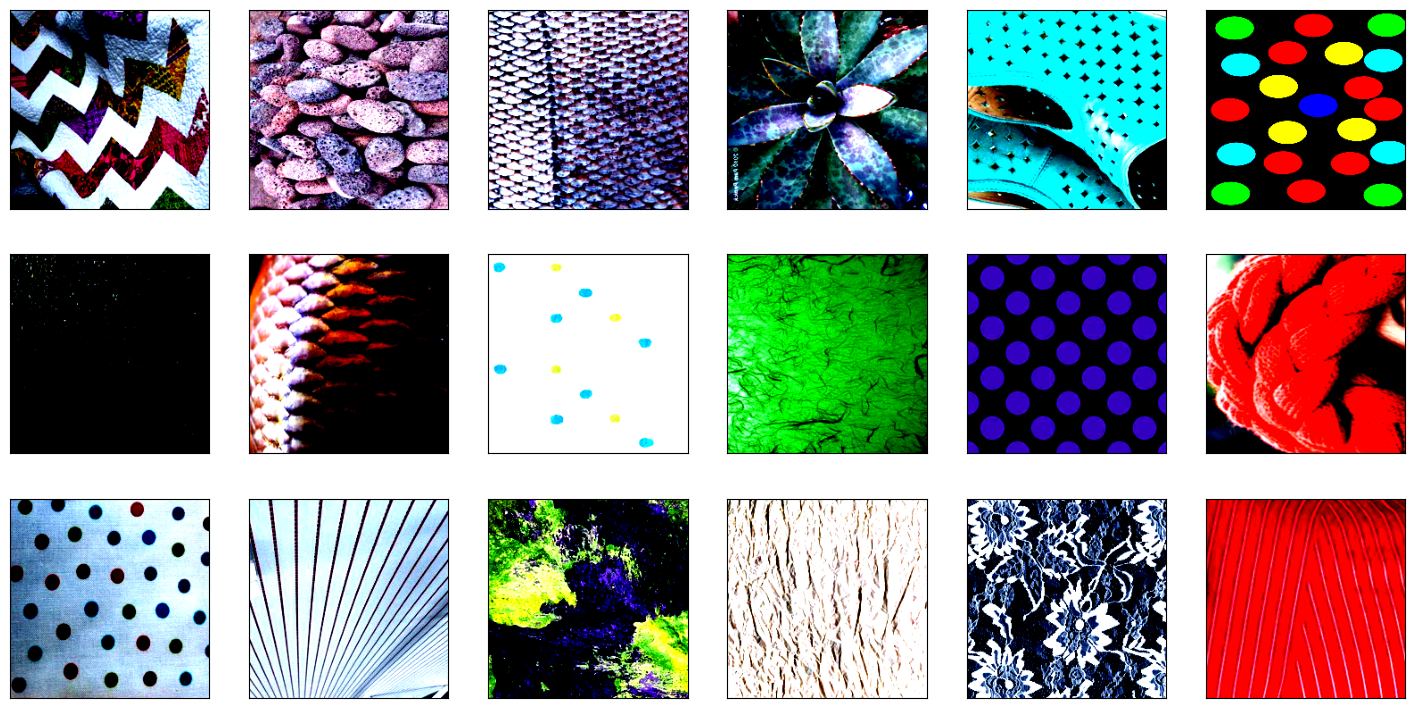

In [24]:
#plota imagens do dataset

imgs = []
for X, y in train_iter:
    X = np.swapaxes(X, 1, 3)
    imgs = X[0:18]
    break


show_images(imgs, 3, 6, titles=None, scale=3)